In [1]:
import scanpy as sc

In [2]:
adata=sc.read("old/whole_neocortex/adata_processed.h5ad")

In [3]:
import pandas as pd
umap=pd.read_table("old/whole_neocortex/cluster_scDevSC.merged.umap.txt",skiprows=1,index_col=0)

In [4]:
adata.obsm["X_umap"]=umap.values

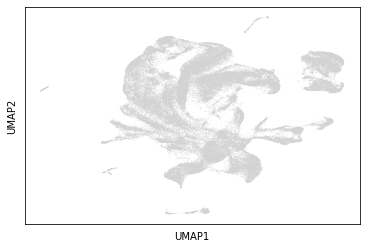

In [5]:
sc.pl.umap(adata)

In [6]:
torem=["Cajal Retzius cells","Oligodendrocytes","Microglia","Interneurons","Endothelial cells","VLMC","Pericytes", "Red blood cells","Doublet","Low quality cells"]

In [7]:
adata=adata[~adata.obs.celltype.isin(torem)]
adata=adata[adata.obs.devtime!="E10"]

/home/lfaure/miniconda3/envs/rapids-22.06/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [8]:
import numpy as np
timepoints = adata.obs["devtime"].cat.categories.tolist()
timepoint_connections = pd.DataFrame(np.array([timepoints[:-1], timepoints[1:]]).T)

In [9]:
import harmony
data_df=pd.DataFrame(adata.obsm["X_pca"],index=adata.obs_names)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
aug_aff, aff = harmony.core.augmented_affinity_matrix(data_df, adata.obs.devtime, timepoint_connections,n_neighbors=100,device="gpu",pc_components=None)

Nearest neighbor computation...
Constucting affinities between E11 and E12...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between E12 and E13...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between E13 and E14...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between E14 and E15...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between E15 and E16...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between E16 and E17...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between E17 and E18...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between E18 and P1...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between P1 and P4...
t+1 neighbors of t...
t neighbors of t+1...


In [12]:
import palantir
dm_res = palantir.utils.run_diffusion_maps(aug_aff)

In [13]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)

In [14]:
adata.obsm["X_ms"]=ms_data.values

In [15]:
sc.pp.neighbors(adata,n_neighbors=100,method="rapids",use_rep="X_ms")

In [16]:
sc.tl.draw_graph(adata,method="rapids",init_pos="X_umap")

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


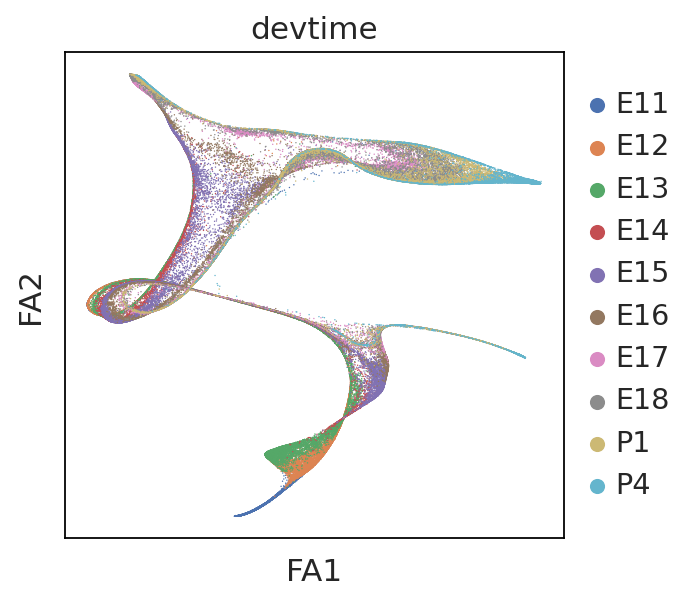

In [18]:
sc.set_figure_params()
sc.pl.draw_graph(adata,color="devtime")

In [43]:
subset=["Intermediate progenitors","Apical progenitors","Cycling glial cells","Astrocytes"]

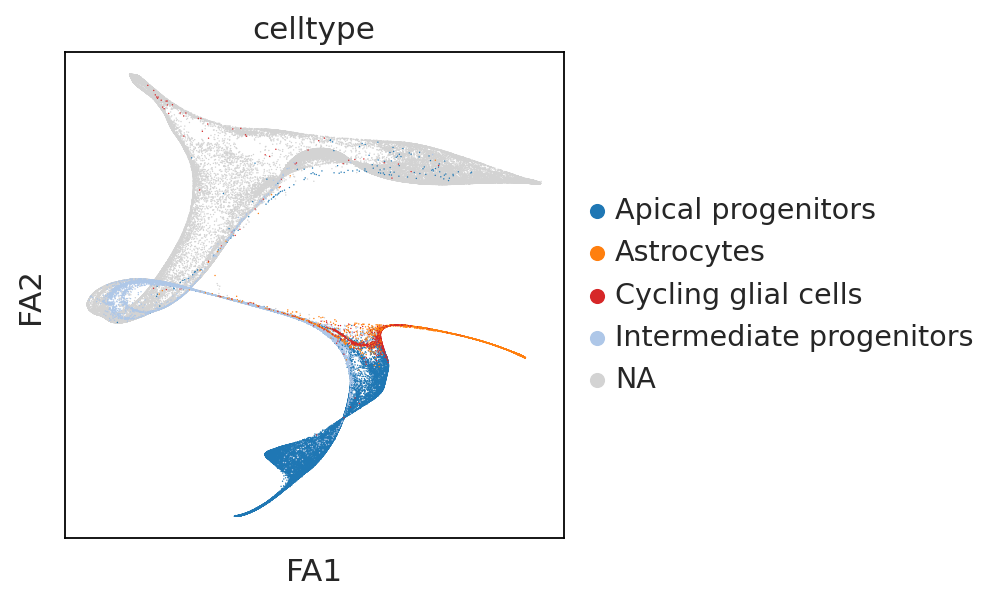

In [44]:
sc.pl.draw_graph(adata,color="celltype",groups=subset)

In [45]:
adata=adata[adata.obs.celltype.isin(subset)]

In [54]:
sc.pp.neighbors(adata,n_neighbors=100,method="rapids",use_rep="X_ms")

In [55]:
sc.tl.draw_graph(adata,method="rapids",init_pos="X_umap")

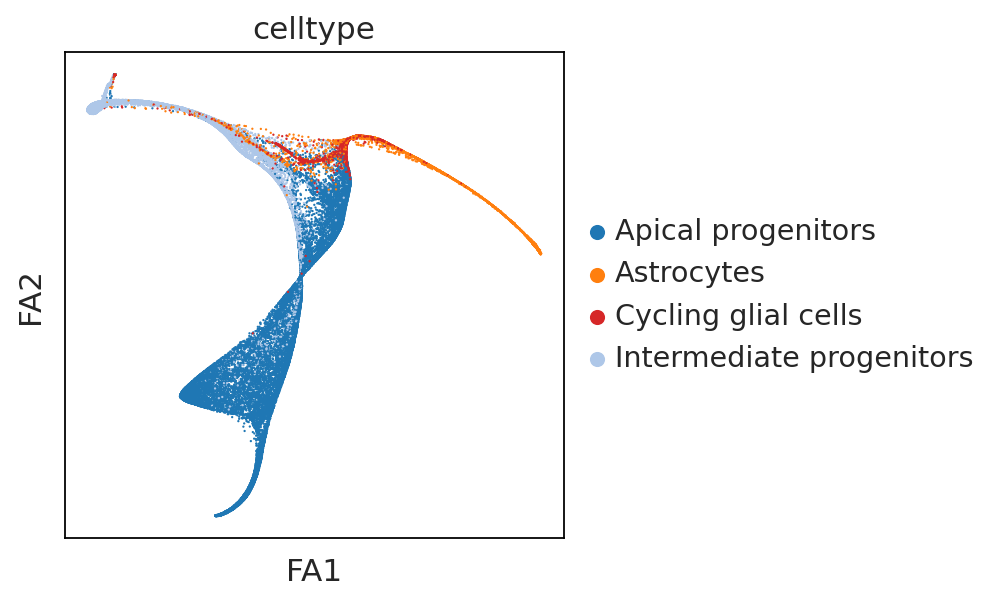

In [56]:
sc.pl.draw_graph(adata,color="celltype",groups=subset)

In [20]:
import scFates as scf

In [50]:
scf.tl.tree(adata,Nodes=500,use_rep="X_ms",method="ppt",device="gpu",seed=42,ppt_sigma=.04,ppt_lambda=1000)

inferring a principal tree inferring a principal tree --> parameters used 
    500 principal points, sigma = 0.04, lambda = 1000, metric = euclidean
    fitting: 100%|██████████| 50/50 [00:03<00:00, 14.48it/s]
    inference not converged (error: 0.009121465227308109)
    finished (0:00:03) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


    graph cleaned --> removed 8 principal points


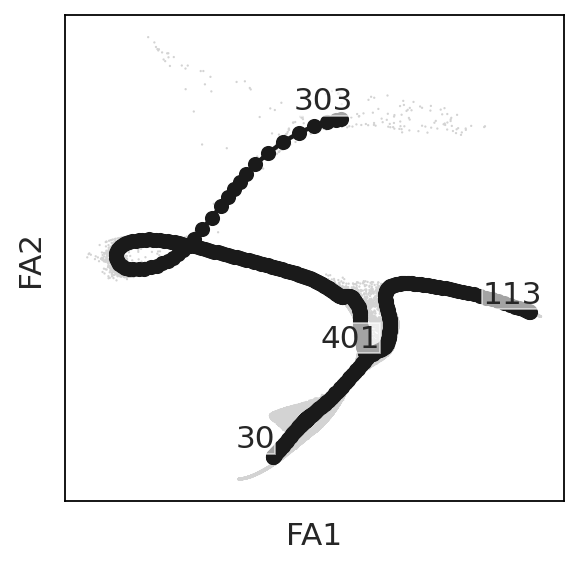

In [52]:
scf.tl.cleanup(adata,minbranchlength=10)
scf.pl.graph(adata,basis="draw_graph_fa")

In [53]:
scf.tl.root(adata,30)

node 30 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [57]:
scf.tl.pseudotime(adata,n_jobs=40,n_map=100)

projecting cells onto the principal graph
    mappings: 100%|██████████| 100/100 [01:47<00:00,  1.08s/it]
    finished (0:02:08) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


... storing 'seg' as categorical


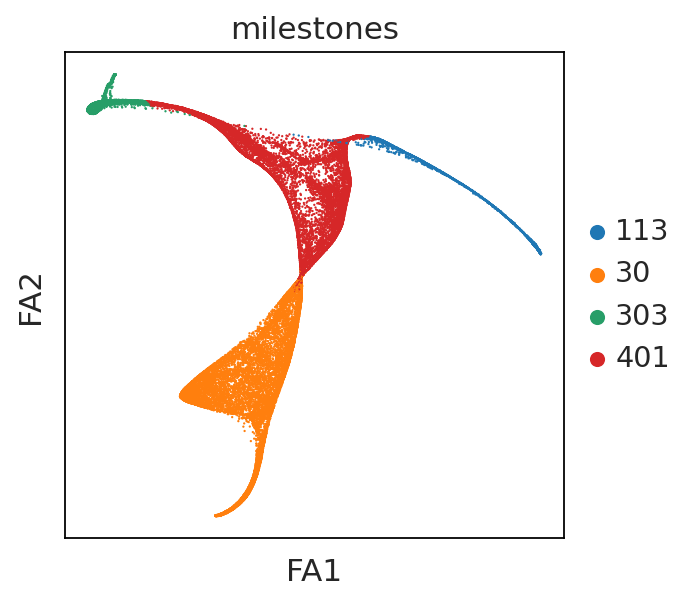

In [58]:
sc.pl.draw_graph(adata,color="milestones")

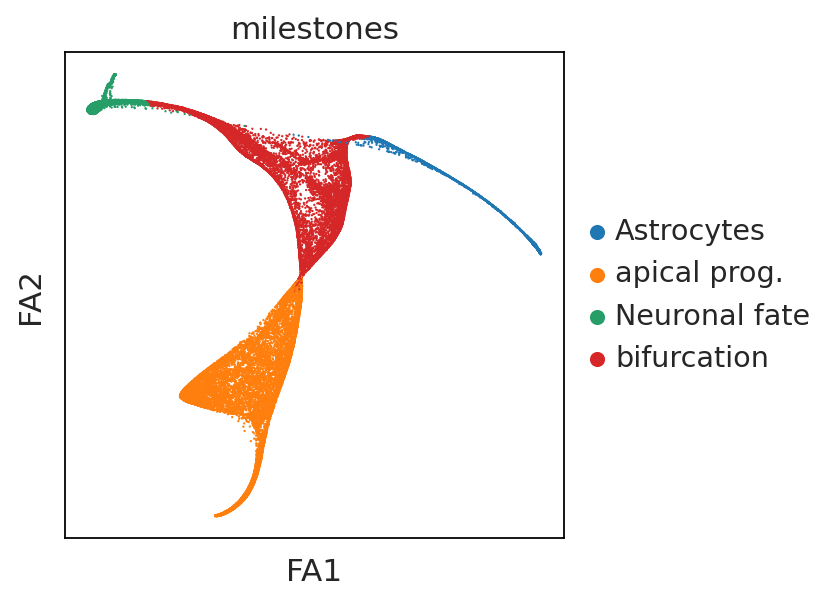

In [60]:
scf.tl.rename_milestones(adata,["Astrocytes","apical prog.","Neuronal fate","bifurcation"])
sc.pl.draw_graph(adata,color="milestones")

In [65]:
adata=adata.raw.to_adata()

In [66]:
scf.tl.test_association(adata,n_jobs=40)

test features for association with the trajectory
    single mapping : 100%|██████████| 19712/19712 [16:13<00:00, 20.26it/s]
    found 461 significant features (0:16:13) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


In [69]:
scf.tl.test_association(adata,reapply_filters=True,A_cut=.4)

reapplied filters, 2955 significant features


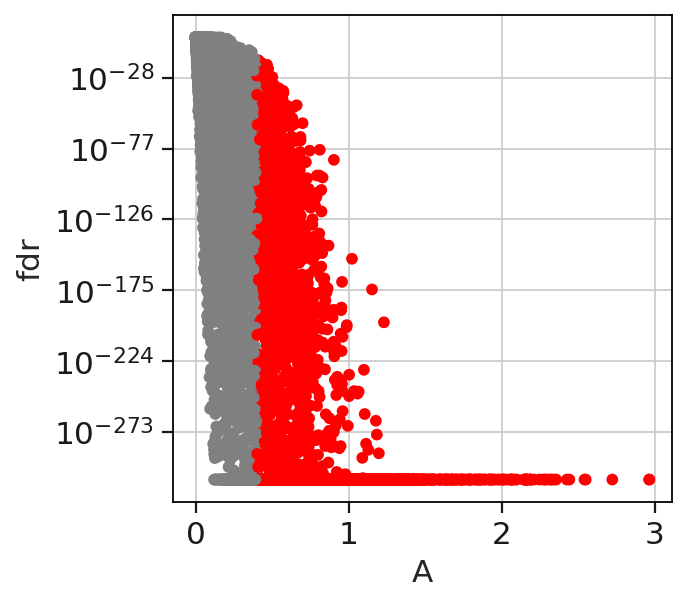

In [70]:
scf.pl.test_association(adata)

In [72]:
adata.write("old/whole_neocortex/adata_tree.h5ad")